In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd


In [4]:
import sys

In [5]:
sys.path.append('C:\\Users\\bwils\\OneDrive\\Documents\\GitHub\\Pump-it-up\\Functions')
sys.path

['C:\\Users\\bwils\\OneDrive\\Documents\\GitHub\\Pump-it-up',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\python39.zip',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\DLLs',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\lib',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup',
 '',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\lib\\site-packages',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\lib\\site-packages\\win32',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\bwils\\anaconda3\\envs\\pumpitup\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\bwils\\.ipython',
 'C:\\Users\\bwils\\OneDrive\\Documents\\GitHub\\Pump-it-up\\Functions']

In [14]:
new_path = %pwd
new_path = new_path + '\\Functions'
new_path

'C:\\Users\\bwils\\OneDrive\\Documents\\GitHub\\Pump-it-up\\Functions'

In [13]:
new_path + 'm'

'C:\\Users\\bwils\\OneDrive\\Documents\\GitHub\\Pump-it-upm'

In [32]:
import get_feature_name as get
import model_transformer as tran

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
#from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [22]:
model_data = pd.read_pickle('Data/model_data.pkl')

In [23]:
model_data.columns

Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
       'district_code', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'lga_Njombe', 'year', 'month',
       'years_old', 'popbins'],
      dtype='object')

In [24]:
model_data.drop(columns=['id'], inplace=True)

In [25]:
num_cols = ['gps_height', 'population']
cat_cols = ['basin', 'region_code', 'district_code', 'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'amount_tsh', 'popbins']

In [26]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True)

In [38]:
def prep_train(unprepped_values, class_col):
    train_X, test_X, train_y, test_y = train_test_split(unprepped_values.drop(columns=[class_col]), 
                                                        unprepped_values[class_col], test_size=0.25, random_state=42)
    train_Xct = CT.fit_transform(train_X)
    
    test_Xct = CT.transform(test_X)

    cols = get_feature_names(CT)
    train_Xf = pd.DataFrame(train_Xct.todense(), columns=cols)
    cols = get_feature_names(CT)
    test_Xf = pd.DataFrame(test_Xct.todense(), columns=cols)
    
    return train_Xf, train_y, test_Xf, test_y   

In [28]:
def prep_submit(unprepped_values):
    submit_X= unprepped_values
        
    submit_Xt = model_transformer(submit_X)
    submit_Xct = CT.transform(submit_Xt)

    cols = get_feature_names(CT)
    submit_Xf = pd.DataFrame(submit_Xct.todense(), columns=cols)
    
    return submit_Xf

In [35]:
def model_transformer(model_data):
    #Applies transformations from EDA notebook to training and testing sets to ensure same changes are made
    #Correct names in extraction_type
    data = model_data
    
    data['extraction_type'].replace({'other - swn 81':'other-handpump',
                                 'other - play pump':'other-handpump', 
                                 'walimi':'other-handpump', 
                                 'other - mkulima/shinyanga':'other-handpump',
                                'swn 80':'swn_80',
                                 'nira/tanira':'nira-tanira',
                                'india mark ii':'india_mark_ii',
                                'india mark iii':'india_mark_iii',
                                'other - rope pump':'other-rope_pump',}, inplace=True)
    #correct names in source
    data['source'].replace({'shallow well':'shallow_well',
                       'machine dbh':'machine_dbh',
                       'rainwater harvesting':'rainwater_harvesting',
                       'hand dtw':'hand_dtw'}, inplace=True)

    #Group low count subvillages in other
    counts = data['subvillage'].value_counts()
    counts = counts.loc[counts >=200]
    counts = list(counts.index)
    data.loc[~data['subvillage'].isin(counts), 'subvillage'] = 'other'

    data.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'public_meeting':False, 
                                 'scheme_management':'unknown', 'scheme_name':'unknown'})

    #create and boolean lga_Njombe column
    data['lga_Njombe'] = data['lga'].replace({'Njombe':1})
    data.loc[data['lga_Njombe']!=1, 'lga_Njombe'] = 0
    data['lga_Njombe'] = data['lga_Njombe'].astype('int')

    #remove slashes from basin names
    data['basin'].replace({'Ruvuma / Southern Coast':'Ruvuma-Southern_Coast',
                     'Wami / Ruvu':'Wami-Ruvu'}, inplace=True)

    #convert date_recorded column to datetime object and edxtract month and year
    data['date_recorded']= pd.to_datetime(data['date_recorded'])
    data['date_recorded'].describe(datetime_is_numeric=True)
    data['year']=data['date_recorded'].dt.year
    data['month']=data['date_recorded'].dt.month

    ##Convert public_meeting column to 1 or 0
    data['public_meeting'] = data['public_meeting'].map({True:1, False:0})

    #Convert permit column to 1 or 0
    data['permit'] = data['permit'].map({True:1, False:0})

    #Correct construction_year with 1999, create years_old column
    data['construction_year'].replace({0:1999}, inplace=True)
    data['construction_year'] = pd.to_datetime(data['construction_year'], format='%Y')
    data['years_old'] = data['date_recorded'].dt.year - data['construction_year'].dt.year

    #Group low count scheme_names under other
    counts2 = data['scheme_name'].value_counts()
    counts2 = counts2.loc[counts2 >=200]
    counts2 = list(counts2.index)
    data.loc[~data['scheme_name'].isin(counts2), 'scheme_name'] = 'other'
    
    #group low count funders under other
    counts3 = data['funder'].value_counts()
    counts3 = counts3.loc[counts3 >=500]
    counts3 = list(counts3.index)
    data.loc[~data['funder'].isin(counts3), 'funder'] = 'other'
    data.loc[data['funder']=='Government Of Tanzania', 'funder'] = 'gov_tanz'

    #Group low count installers under other
    counts4 = data['installer'].value_counts()
    counts4 = counts4.loc[counts4 >=500]
    counts4 = list(counts4.index)
    data.loc[~data['installer'].isin(counts4), 'installer'] = 'other'
    
    #Create column for population bins
    data['popbins'] = pd.cut(data['population'], [-1,2,250,500,1000,2500,10000,40000], labels=list(range(1,8)))
    
    #Amount_TSH - Change to bins
    data.loc[data['amount_tsh']>5000, 'amount_tsh'] = 5000
    data.loc[data['amount_tsh']>0, 'amount_tsh'] = pd.qcut(data.loc[data['amount_tsh']>0, 'amount_tsh'], 
                                                           q=5, duplicates='drop',labels=False)           
    
    #Ward Feature - Change to Bins
    counts5 = data['ward'].value_counts()
    verybig = counts5.loc[counts5.between(200,400)].index
    big = counts5.loc[counts5.between(100,200)].index
    medium = counts5.loc[counts5.between(50,100)].index
    small = counts5.loc[counts5.between(25,50)].index
    verysmall = counts5.loc[counts5 <=25].index
    data.loc[data['ward'].isin(verybig), 'ward'] = 'verybig'
    data.loc[data['ward'].isin(big), 'ward'] = 'big'
    data.loc[data['ward'].isin(medium), 'ward'] = 'medium'
    data.loc[data['ward'].isin(small), 'ward'] = 'small'
    data.loc[data['ward'].isin(verysmall), 'ward'] = 'verysmall'
    
    #Latitude-Longitiude - Correct near zero values
    data.loc[data['longitude'] == 0, 'longitude'] = np.random.choice(range(31,33))
    data.loc[data['latitude']>-0.01, 'latitude'] = -1*np.random.choice(range(1,2))
    
    gps_trainX = data.loc[data['gps_height']>0, ['latitude', 'longitude']]
    gps_trainy = data.loc[data['gps_height']>0, ['gps_height']]
    knn_gps = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
    knn_gps.fit(gps_trainX, gps_trainy)
    data.loc[data['gps_height']<=0, ['gps_height']] = knn_gps.predict(data.loc[data['gps_height']<=0, 
                                                                           ['latitude', 'longitude']])
    
    tsh_trainX = data[['latitude', 'longitude']]
    scaler = StandardScaler()
    gps_train = scaler.fit_transform(data['gps_height'].values.reshape(-1,1))
    tsh_trainX.insert(1, value=gps_train, column='gps_height')
    tsh_trainX.insert(0, column = 'tsh', value=data['amount_tsh'])
    tsh_trainX = tsh_trainX.loc[tsh_trainX['tsh'].between(1,4999)]
    tsh_trainX.drop(columns=['tsh'], inplace=True)
    tsh_trainy = data.loc[data['amount_tsh'].between(1,4999), ['amount_tsh']]
    knn_tsh = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
    knn_tsh.fit(tsh_trainX, tsh_trainy)
    tsh_fillX = data[['latitude', 'longitude']]
    gps_fill = scaler.transform(data['gps_height'].values.reshape(-1,1))
    tsh_fillX.insert(1, value=gps_fill, column='gps_height')
    tsh_fillX.insert(0, column = 'tsh', value=data['amount_tsh'])
    tsh_fillX = tsh_fillX.loc[~tsh_fillX['tsh'].between(1,4999)]
    tsh_fillX.drop(columns=['tsh'], inplace=True)
    data.loc[~data['amount_tsh'].between(1,4999), ['amount_tsh']] = knn_tsh.predict(tsh_fillX)
    
    data.drop(columns=['source_type', 'source_class', 'extraction_type_group', 'extraction_type_class', 
                       'region', 'wpt_name', 'num_private', 'recorded_by', 'quality_group', 'quantity_group',
                       'waterpoint_type_group', 'payment', 'construction_year', 'date_recorded', 'lga'], inplace=True)
    return data

In [36]:
import warnings
import sklearn

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


In [ ]:
train_Xf, train_y, test_Xf, test_y = prep_train(model_data, 'class')

In [ ]:
pca = PCA()
pca.fit(train_Xf.drop(columns=['scaler__gps_height']))
pca.explained_variance_ratio_[:10]

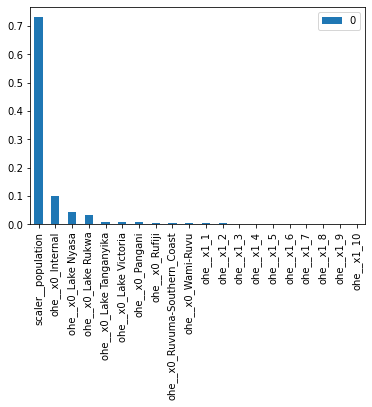

In [77]:
ex_var = pd.DataFrame(pca.explained_variance_ratio_.reshape(1,-1), columns=train_Xf.drop(columns=['scaler__gps_height']).columns).T.sort_values(by=0, ascending=False)
ex_var.head(20).plot(kind='bar')
plt.show()

In [78]:
pca = PCA()
pca.fit(train_Xf)#.drop(columns=['scaler__gps_height']))
pca.explained_variance_ratio_[:10]

array([0.72578769, 0.10142577, 0.04368408, 0.03434548, 0.00912386,
       0.00737392, 0.00619062, 0.00408544, 0.00369079, 0.00328998])

In [ ]:
ex_var = pd.DataFrame(pca.singular_values_.reshape(1,-1), columns=train_Xf.columns).T.sort_values(by=0, ascending=False)
ex_var.head(20).plot(kind='bar')
plt.show()

In [80]:
rf = RandomForestClassifier(n_estimators = 150, criterion='entropy', max_depth=16, 
                            class_weight={'functional':1,'non functional':1.25,'funtional needs repair':10})
rf.fit(train_Xf, train_y)
rf.score(test_Xf, test_y)

0.7953535353535354

In [120]:
feed = pca.transform(train_Xf)
xgbpca = XGBClassifier()
rsearchpca = RandomizedSearchCV(xgbpca, param_distribution={'n_estimators'=[50, 100, 150, 200, 250], 
                                                             'max_depth'=[1, 2, 5, 10, 16, 25], 
                                                            'learning_rate'=[.5, 1, 1.5, 2, 2.5]})

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-120-382e4bceff6a>, line 3)

In [102]:
def model_transformer(model_data):
    #Applies transformations from EDA notebook to training and testing sets to ensure same changes are made
    #Correct names in extraction_type
    data = model_data
    
    data['extraction_type'].replace({'other - swn 81':'other-handpump',
                                 'other - play pump':'other-handpump', 
                                 'walimi':'other-handpump', 
                                 'other - mkulima/shinyanga':'other-handpump',
                                'swn 80':'swn_80',
                                 'nira/tanira':'nira-tanira',
                                'india mark ii':'india_mark_ii',
                                'india mark iii':'india_mark_iii',
                                'other - rope pump':'other-rope_pump',}, inplace=True)
    #correct names in source
    data['source'].replace({'shallow well':'shallow_well',
                       'machine dbh':'machine_dbh',
                       'rainwater harvesting':'rainwater_harvesting',
                       'hand dtw':'hand_dtw'}, inplace=True)

    #Group low count subvillages in other
    counts = data['subvillage'].value_counts()
    counts = counts.loc[counts >=200]
    counts = list(counts.index)
    data.loc[~data['subvillage'].isin(counts), 'subvillage'] = 'other'

    data.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'public_meeting':False, 
                                 'scheme_management':'unknown', 'scheme_name':'unknown'})

    #create and boolean lga_Njombe column
    data['lga_Njombe'] = data['lga'].replace({'Njombe':1})
    data.loc[data['lga_Njombe']!=1, 'lga_Njombe'] = 0
    data['lga_Njombe'] = data['lga_Njombe'].astype('int')

    #remove slashes from basin names
    data['basin'].replace({'Ruvuma / Southern Coast':'Ruvuma-Southern_Coast',
                     'Wami / Ruvu':'Wami-Ruvu'}, inplace=True)

    #convert date_recorded column to datetime object and edxtract month and year
    data['date_recorded']= pd.to_datetime(data['date_recorded'])
    data['date_recorded'].describe(datetime_is_numeric=True)
    data['year']=data['date_recorded'].dt.year
    data['month']=data['date_recorded'].dt.month

    ##Convert public_meeting column to 1 or 0
    data['public_meeting'] = data['public_meeting'].map({True:1, False:0})

    #Convert permit column to 1 or 0
    data['permit'] = data['permit'].map({True:1, False:0})

    #Correct construction_year with 1999, create years_old column
    data['construction_year'].replace({0:1999}, inplace=True)
    data['construction_year'] = pd.to_datetime(data['construction_year'], format='%Y')
    data['years_old'] = data['date_recorded'].dt.year - data['construction_year'].dt.year

    #Group low count scheme_names under other
    counts2 = data['scheme_name'].value_counts()
    counts2 = counts2.loc[counts2 >=200]
    counts2 = list(counts2.index)
    data.loc[~data['scheme_name'].isin(counts2), 'scheme_name'] = 'other'
    
    #group low count funders under other
    counts3 = data['funder'].value_counts()
    counts3 = counts3.loc[counts3 >=500]
    counts3 = list(counts3.index)
    data.loc[~data['funder'].isin(counts3), 'funder'] = 'other'
    data.loc[data['funder']=='Government Of Tanzania', 'funder'] = 'gov_tanz'

    #Group low count installers under other
    counts4 = data['installer'].value_counts()
    counts4 = counts4.loc[counts4 >=500]
    counts4 = list(counts4.index)
    data.loc[~data['installer'].isin(counts4), 'installer'] = 'other'
    
    #Create column for population bins
    data['popbins'] = pd.cut(data['population'], [-1,2,250,500,1000,2500,10000,40000], labels=list(range(1,8)))
    
    #Amount_TSH - Change to bins
    data.loc[data['amount_tsh']>5000, 'amount_tsh'] = 5000
    data.loc[data['amount_tsh']>0, 'amount_tsh'] = pd.qcut(data.loc[data['amount_tsh']>0, 'amount_tsh'], 
                                                           q=5, duplicates='drop',labels=False)           
    
    #Ward Feature - Change to Bins
    counts5 = data['ward'].value_counts()
    verybig = counts5.loc[counts5.between(200,400)].index
    big = counts5.loc[counts5.between(100,200)].index
    medium = counts5.loc[counts5.between(50,100)].index
    small = counts5.loc[counts5.between(25,50)].index
    verysmall = counts5.loc[counts5 <=25].index
    data.loc[data['ward'].isin(verybig), 'ward'] = 'verybig'
    data.loc[data['ward'].isin(big), 'ward'] = 'big'
    data.loc[data['ward'].isin(medium), 'ward'] = 'medium'
    data.loc[data['ward'].isin(small), 'ward'] = 'small'
    data.loc[data['ward'].isin(verysmall), 'ward'] = 'verysmall'
    
    #Latitude-Longitiude - Correct near zero values
    data.loc[data['longitude'] == 0, 'longitude'] = np.random.choice(range(31,33))
    data.loc[data['latitude']>-0.01, 'latitude'] = -1*np.random.choice(range(1,2))
    
    lin_gps_trainX = data.loc[data['gps_height']>0, ['latitude', 'longitude']]
    lin_gps_trainy = data.loc[data['gps_height']>0, ['gps_height']]
    lin = LinearRegression()
    lin.fit(lin_gps_trainX, lin_gps_trainy)
    data.loc[data['gps_height']<=0, ['gps_height']] = lin.predict(data.loc[data['gps_height']<=0, ['latitude', 'longitude']])
    
    data.drop(columns=['source_type', 'source_class', 'extraction_type_group', 'extraction_type_class', 
                       'region', 'wpt_name', 'num_private', 'recorded_by', 'quality_group', 'quantity_group',
                       'waterpoint_type_group', 'payment', 'construction_year', 'date_recorded', 'lga', 'id'], inplace=True)
    return data

In [109]:
submit_values= pd.read_csv('Source_data/testset_values.csv')

In [105]:
submit_Xf = prep_submit(submit_values)

<ipython-input-51-2f824cd414e6>:35: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [116]:
y_pred = rf.predict(submit_Xf)

In [117]:
submission2 = pd.DataFrame(y_pred, columns=['status_group'])
submission2['id'] = submit_values['id']

In [118]:
submission2.to_csv('submission3_BW.csv')

In [100]:
xgb = XGBClassifier()
xgb.fit(train_Xf, train_y)
xgb.score(test_Xf, test_y)

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:45:31] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7886868686868687

In [115]:
xgbsam = XGBClassifier()
xgbsam.fit(train_Xfsampled, train_ysampled)
xgbsam.score(test_Xfsampled, test_ysampled)

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:48] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8118

In [71]:
train_y

24947    non functional
22630        functional
13789        functional
15697        functional
22613    non functional
              ...      
54343        functional
38158        functional
860      non functional
15795        functional
56422    non functional
Name: label, Length: 44550, dtype: object

In [84]:
class1 = model_data.loc[model_data['class']=='functional'].sample(100000, replace=True)
class2 = model_data.loc[model_data['class']=='non functional'].sample(100000, replace=True)
class3 = model_data.loc[model_data['class']=='functional needs repair'].sample(100000, replace=True)
sampled_values = pd.concat([class1, class2, class3])

In [86]:
sampled_values['class'].value_counts()

functional needs repair    100000
functional                 100000
non functional             100000
Name: class, dtype: int64

In [160]:
sampled_values.iloc[:,1].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [87]:
sampled_values['class'] = sampled_values['class'].map({'functional':1, 'non functional':2, 'functional needs repair':3})

In [88]:
sampled_values['class'].unique()

array([1, 2, 3], dtype=int64)

In [89]:
sampled_values['funder'].unique().shape

(21,)

In [91]:
train_Xfsampled, train_ysampled, test_Xfsampled, test_ysampled = prep_train(sampled_values, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   1.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


<ipython-input-51-2f824cd414e6>:35: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [92]:
rfsampled = RandomForestClassifier(n_estimators = 150, criterion='entropy', max_depth=16)
rfsampled.fit(train_Xfsampled, train_ysampled)
rfsampled.score(test_Xfsampled, test_ysampled)

0.8728133333333333

In [112]:
imp = pd.DataFrame(rfsampled.feature_importances_, index=train_Xfsampled.columns).sort_values(by=0, ascending=False)

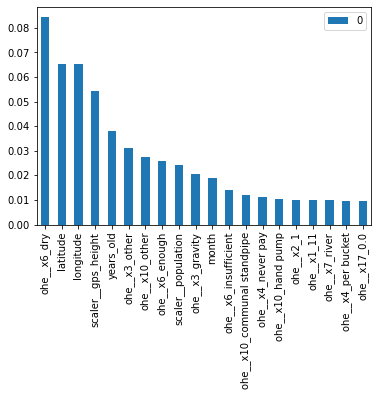

In [113]:
imp.head(20).plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(trainXf, train_y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(test_Xf, test_y)
print('Accuracy: %.2f' % (accuracy*100))

In [149]:
train_Xfsampled.columns

Index(['scaler__gps_height', 'scaler__population', 'ohe__x0_Internal',
       'ohe__x0_Lake Nyasa', 'ohe__x0_Lake Rukwa', 'ohe__x0_Lake Tanganyika',
       'ohe__x0_Lake Victoria', 'ohe__x0_Pangani', 'ohe__x0_Rufiji',
       'ohe__x0_Ruvuma-Southern_Coast',
       ...
       'ohe__x18_6', 'ohe__x18_7', 'longitude', 'latitude', 'public_meeting',
       'permit', 'lga_Njombe', 'year', 'month', 'years_old'],
      dtype='object', length=290)

In [133]:
xgbsampled = XGBClassifier(use_label_encoder=False)
xgbsampled.fit(train_Xfsampled, train_ysampled)
xgbsampled.score(test_Xfsampled, test_ysampled)

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:13:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7405866666666666

In [94]:
submit_values= pd.read_csv('Source_data/testset_values.csv')

In [95]:
submit_Xf = prep_submit(submit_values)

<ipython-input-59-2f47c8d752fa>:33: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [98]:
y_pred = rf.predict(submit_Xf)

In [81]:
xgb = XGBClassifier()
xgb.fit(train_Xf, train_y)
xgb.score(test_Xf, test_y)

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7954208754208755

In [ ]:
#data_test.columns == data.drop(columns=['label']).columns

In [20]:
values = pd.read_csv('Source_data/trainset_values.csv')
labels = pd.read_csv('Source_data/trainset_labels.csv')
values.insert(loc=1, column='label', value=labels['status_group'])
train_X, test_X, train_y, test_y = train_test_split(values.drop(columns=['label']), values['label'], 
                                                    test_size=0.25, random_state=42)
model1.fit(train_X, train_y)

[Pipeline] ............... (step 1 of 3) Processing EDA, total=   0.3s
[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
[Pipeline] ................ (step 2 of 3) Processing CT, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing model, total= 2.3min


Pipeline(steps=[('EDA',
                 FunctionTransformer(func=<function test_transformer at 0x000001A04B91D430>)),
                ('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['gps_height', 'population']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['basin', 'region_code',
                                                   'district_code',
                                                   'extraction_type',
                                                   'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source', 'management',
                                                   'management_group',
                                                   'waterpo

In [21]:
model1.score(test_X, test_y)

0.7975084175084175

In [22]:
model1.feature_importances_

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [ ]:
svc_predict = model.predict()

In [ ]:
rs = RandomizedSearch()

In [ ]:
data2.columns

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first')

In [ ]:
train_num = data2.loc[:,]

In [ ]:
for c in train_num.columns:
    train_num[c] = scaler.fit_transform(train_num.loc[:,c].to_numpy().reshape(-1,1))#

In [ ]:
train_num

In [ ]:
colt = ColumnTransformer([('basin', ohe, ['basin']), 
                          ('r_code', ohe, ['region_code']), 
                          ('d_code', ohe, ['district_code']), 
                          ('ex', ohe, ['extraction_type']), 
                          ('pay', ohe, ['payment_type']), 
                          ('qual', ohe, ['water_quality']),
                          ('quant', ohe, ['quantity']), 
                          ('s_type', ohe, ['source']),
                          ('mang', ohe, ['management']),
                          ('mang_g', ohe, ['management_group']),
                          ('wp_type', ohe, ['waterpoint_type']),
                         ('fund', ohe, ['funder']),
                         ('inst', ohe, ['installer']),
                         ('subv', ohe, ['subvillage']),
                         ('ward', ohe, ['ward']),
                         ('sch_man', ohe, ['scheme_management']),
                         ('sch', ohe, ['scheme_name'])])

In [ ]:
train_cat = data2.loc[:,]
train_df = colt.fit_transform(train_cat).toarray()

In [ ]:
train_cat = pd.DataFrame(train_df, columns=colt.get_feature_names())

In [ ]:
train = train_num.merge(train_cat, left_index=True, right_index=True)

In [ ]:
train

In [ ]:
train.shape

In [ ]:
train = train.merge(data2[['lga_Njombe', 'year', 'month', 'tsh_bin', 'years_old', 'popbins', 'longitude', 'latitude', 
                          'public_meeting', 'permit']], left_index=True, right_index=True)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(train, data2['label'], test_size=0.25, random_state=42)

In [ ]:
rf = RandomForestClassifier()
params = {'n_estimators':[10, 100, 200, 500], 'criterion':['gini', 'entropy']}
rs = RandomizedSearchCV(rf, params, n_iter=5)

In [ ]:
rf.fit(train_X, train_y)
rf.score(test_X, test_y)

In [ ]:
rs.fit(train_X, train_y)
rs.best_estimator_
rs.cv_results_

In [ ]:
rf.classes_

In [ ]:
features = pd.Series(rf.feature_importances_, index=train.columns)

In [ ]:
features.sort_values(ascending=False).head(20)

In [ ]:
data2['label2'] = data2['label'].replace({'functional needs repair':'functional'})

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(train, data2['label'], test_size=0.25, random_state=42)

In [ ]:
rf.fit(train_X, train_y)
rf.score(test_X, test_y)

In [ ]:
rs.score(test_X, test_y)

In [ ]:
y_pred = rs.predict(test_X)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm=confusion_matrix(test_y, y_pred, labels=rs.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rs.classes_)
plt.figure(figsize=(40,8))
disp.plot()

In [ ]:
test_X.insert(2,value=y_pred, column='prediction')

In [ ]:
test_X

In [ ]:
y_pred = rs.predict(train)

In [ ]:
rs.score(train, data2['label'])

In [ ]:
data2.insert(2, value=y_pred, column='prediction')

In [ ]:
data2.head()

In [ ]:
errors = data2.loc[data2['label']!=data2['prediction']]
errors

In [ ]:
correct = data2.loc[data2['label']==data2['prediction']]
correct

In [ ]:
errors.describe()

In [ ]:
sns.scatterplot(data=errors, x='longitude', y='latitude')
plt.show()

In [ ]:
errors['amount_tsh'].plot(c='red')
data2['amount_tsh'].plot(c='blue')
plt.show()

In [ ]:
submit_X = pd.read_csv('Source_data/testset_values.csv')

In [ ]:
train_num = submit_X.loc[:,['amount_tsh', 'gps_height', 'population',]]

In [ ]:
for c in train_num.columns:
    train_num[c] = scaler.fit_transform(train_num.loc[:,c].to_numpy().reshape(-1,1))#

In [ ]:
train_num

In [ ]:
colt = ColumnTransformer([('basin', ohe, ['basin']), 
                          ('r_code', ohe, ['region_code']), 
                          ('d_code', ohe, ['district_code']), 
                          ('ex', ohe, ['extraction_type']), 
                          ('pay', ohe, ['payment_type']), 
                          ('qual', ohe, ['water_quality']),
                          ('quant', ohe, ['quantity']), 
                          ('s_type', ohe, ['source']),
                          ('mang', ohe, ['management']),
                          ('mang_g', ohe, ['management_group']),
                          ('wp_type', ohe, ['waterpoint_type']),
                         ('fund', ohe, ['funder']),
                         ('inst', ohe, ['installer']),
                         ('subv', ohe, ['subvillage']),
                         ('ward', ohe, ['ward']),
                         ('sch_man', ohe, ['scheme_management']),
                         ('sch', ohe, ['scheme_name'])])

In [ ]:
train_cat = submit_X.loc[:,['basin', 'region_code', 'district_code', 'extraction_type', 'payment_type', 'water_quality', 
                           'quantity', 'source', 'management', 'management_group', 'waterpoint_type', 
                           'funder', 'installer', 'subvillage', 'ward', 'scheme_management', 'scheme_name']]
train_df = colt.fit_transform(train_cat).toarray()

In [ ]:
train_df

In [ ]:
train_cat = pd.DataFrame(train_df, columns=colt.get_feature_names())

In [ ]:
train_cat

In [ ]:
train = train_num.merge(train_cat, left_index=True, right_index=True)

In [ ]:
train.shape

In [ ]:
train.shape

In [ ]:
train = train.merge(data2[['lga_Njombe', 'year', 'month', 'tsh_bin', 'years_old', 'popbins', 'longitude', 'latitude', 
                          'public_meeting', 'permit']], left_index=True, right_index=True)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(train, data2['label'], test_size=0.25, random_state=42)

In [ ]:
rf = RandomForestClassifier()
params = {'n_estimators':[10, 100, 200, 500], 'criterion':['gini', 'entropy']}
rs = RandomizedSearchCV(rf, params, n_iter=5)

In [ ]:
rf.fit(train_X, train_y)
rf.score(test_X, test_y)

In [ ]:
submition = rf.predict(sub_train)

In [ ]:
submission1 = pd.DataFrame(submition, columns=['status_group'])
submission1['id'] = submit_X['id']

In [ ]:
submission1.to_csv('submission1_BW.csv')

In [ ]:
def test_transformer(data):
    data = data.drop(columns=['source_type', 'source_class'])

    data = data.drop(columns=['extraction_type_group', 'extraction_type_class'])
    data['extraction_type'].replace({'other - swn 81':'other-handpump',
                                 'other - play pump':'other-handpump', 
                                 'walimi':'other-handpump', 
                                 'other - mkulima/shinyanga':'other-handpump',
                                'swn 80':'swn_80',
                                 'nira/tanira':'nira-tanira',
                                'india mark ii':'india_mark_ii',
                                'india mark iii':'india_mark_iii',
                                'other - rope pump':'other-rope_pump',}, inplace=True)

    data['source'].replace({'shallow well':'shallow_well',
                       'machine dbh':'machine_dbh',
                       'rainwater harvesting':'rainwater_harvesting',
                       'hand dtw':'hand_dtw'}, inplace=True)

    counts = data['subvillage'].value_counts()
    counts = counts.loc[counts >=200]
    counts = list(counts.index)
    data.loc[~data['subvillage'].isin(counts), 'subvillage'] = 'other'

    data.drop(columns=['region'], inplace=True)

    data.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'public_meeting':False, 
                                 'scheme_management':'unknown', 'scheme_name':'unknown'})

    data['lga_Njombe'] = data['lga'].replace({'Njombe':1})
    data.loc[data['lga_Njombe']!=1, 'lga_Njombe'] = 0

    data.drop(columns=['payment'], inplace=True)

    data['basin'].replace({'Ruvuma / Southern Coast':'Ruvuma-Southern_Coast',
                     'Wami / Ruvu':'Wami-Ruvu'}, inplace=True)

    data['date_recorded']= pd.to_datetime(data['date_recorded'])
    data['date_recorded'].describe(datetime_is_numeric=True)
    data['year']=data['date_recorded'].dt.year
    data['month']=data['date_recorded'].dt.month

    data.drop(columns=['wpt_name', 'num_private', 'recorded_by'], inplace=True)

    data['amount_tsh'] = data['amount_tsh'].astype('int')
    data['tsh_bin'] = pd.cut(data['amount_tsh'], [-1, 1, 20.0, 30.0, 50.0, 100.0, 250, 500.0, 1000.0, 2200.0, 70000.0, 500000],
                         labels=list(range(1,12)))

    data['public_meeting'] = data['public_meeting'].map({True:1, False:0})

    data['permit'] = data['permit'].map({True:1, False:0})

    data['construction_year'].replace({0:1999}, inplace=True)
    data['construction_year'] = pd.to_datetime(data['construction_year'], format='%Y')
    data['years_old'] = data['date_recorded'].dt.year - data['construction_year'].dt.year

    data.drop(columns=['quality_group', 'quantity_group'], inplace=True)

    data.drop(columns=['waterpoint_type_group'],inplace=True)

    counts2 = data['scheme_name'].value_counts()
    counts2 = counts2.loc[counts2 >=200]
    counts2 = list(counts2.index)
    data.loc[~data['scheme_name'].isin(counts2), 'scheme_name'] = 'other'

    counts3 = data['funder'].value_counts()
    counts3 = counts3.loc[counts3 >=500]
    counts3 = list(counts3.index)
    data.loc[~data['funder'].isin(counts3), 'funder'] = 'other'

    counts4 = data['installer'].value_counts()
    counts4 = counts4.loc[counts4 >=500]
    counts4 = list(counts4.index)
    data.loc[~data['installer'].isin(counts4), 'installer'] = 'other'

    data['popbins'] = pd.cut(data['population'], [-1,2,250,500,1000,2500,10000,40000], labels=list(range(1,8)))

    counts5 = data['ward'].value_counts()
    verybig = counts5.loc[counts5.between(200,400)].index
    big = counts5.loc[counts5.between(100,200)].index
    medium = counts5.loc[counts5.between(50,100)].index
    small = counts5.loc[counts5.between(25,50)].index
    verysmall = counts5.loc[counts5 <=25].index
    data.loc[data['ward'].isin(verybig), 'ward'] = 'verybig'
    data.loc[data['ward'].isin(big), 'ward'] = 'big'
    data.loc[data['ward'].isin(medium), 'ward'] = 'medium'
    data.loc[data['ward'].isin(small), 'ward'] = 'small'
    data.loc[data['ward'].isin(verysmall), 'ward'] = 'verysmall'

    data['longitude'] = data['longitude'].replace({0:np.random.choice(range(31,33))})

In [ ]:
test_transformer(submit_X)

In [ ]:
submit_X.shape, submit_X.columns

In [ ]:
data2.shape, data2.columns